# Import the Data

We are exploring StackOverflow Annual Developer survey data from 2019. The data is available at:
* https://insights.stackoverflow.com/survey in CSV format

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymongo
from pymongo import MongoClient
import json
from datetime import datetime
from pprint import pprint

In [2]:
data = pd.read_csv("./data/developer_survey_2019/survey_results_public.csv")

In [3]:
data.shape

(88883, 85)

In [4]:
data.columns

Index(['Respondent', 'MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource',
       'Employment', 'Country', 'Student', 'EdLevel', 'UndergradMajor',
       'EduOther', 'OrgSize', 'DevType', 'YearsCode', 'Age1stCode',
       'YearsCodePro', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney',
       'MgrWant', 'JobSeek', 'LastHireDate', 'LastInt', 'FizzBuzz',
       'JobFactors', 'ResumeUpdate', 'CurrencySymbol', 'CurrencyDesc',
       'CompTotal', 'CompFreq', 'ConvertedComp', 'WorkWeekHrs', 'WorkPlan',
       'WorkChallenge', 'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev',
       'CodeRevHrs', 'UnitTests', 'PurchaseHow', 'PurchaseWhat',
       'LanguageWorkedWith', 'LanguageDesireNextYear', 'DatabaseWorkedWith',
       'DatabaseDesireNextYear', 'PlatformWorkedWith',
       'PlatformDesireNextYear', 'WebFrameWorkedWith',
       'WebFrameDesireNextYear', 'MiscTechWorkedWith',
       'MiscTechDesireNextYear', 'DevEnviron', 'OpSys', 'Containers',
       'BlockchainOrg', 'BlockchainIs', 'BetterLife'

The data is pretty large. It consists of inputs from almost 89,000 developers. The data is multidimensional. It has 85 columns. Since not all the columns will be used in our analysis we will trim down the dataset as much as we need.

# Data Cleaning

Right below we are eliminating the rows where Language Worked With column is not filled. This is a developer survey and we expect to have at least one language in that column.

In [5]:
cleaned_data = data[pd.notnull(data['LanguageWorkedWith'])]

In [6]:
# Below is convenient method to visualize all columns and their calues in jupyter notebook. Based on the below
#information we will decide on which columns to keep.
cleaned_data.iloc[1].to_dict()

{'Respondent': 2,
 'MainBranch': 'I am a student who is learning to code',
 'Hobbyist': 'No',
 'OpenSourcer': 'Less than once per year',
 'OpenSource': 'The quality of OSS and closed source software is about the same',
 'Employment': 'Not employed, but looking for work',
 'Country': 'Bosnia and Herzegovina',
 'Student': 'Yes, full-time',
 'EdLevel': 'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
 'UndergradMajor': nan,
 'EduOther': 'Taken an online course in programming or software development (e.g. a MOOC)',
 'OrgSize': nan,
 'DevType': 'Developer, desktop or enterprise applications;Developer, front-end',
 'YearsCode': nan,
 'Age1stCode': '17',
 'YearsCodePro': nan,
 'CareerSat': nan,
 'JobSat': nan,
 'MgrIdiot': nan,
 'MgrMoney': nan,
 'MgrWant': nan,
 'JobSeek': 'I am actively looking for a job',
 'LastHireDate': "I've never had a job",
 'LastInt': nan,
 'FizzBuzz': nan,
 'JobFactors': "Financial performance or funding status of the company or 

Below is the filter mask we created containing all the columns we need for our analysis

In [7]:
column_mask = ["MainBranch", "Hobbyist", "Employment", "DevType", "Country", "EdLevel", "YearsCode", "ConvertedComp", "JobSat", "JobSeek", "LanguageWorkedWith", "DatabaseWorkedWith", "WebFrameWorkedWith", "SOVisitFreq", "Age", "Gender"]

In [8]:
# Apply mask
simple_data = cleaned_data[column_mask]

In [9]:
simple_data = simple_data[simple_data.LanguageWorkedWith.notnull() & simple_data.ConvertedComp.notnull() & simple_data.JobSat.notnull() & simple_data.DevType.notnull()]

In [10]:
simple_data

,MainBranch,Hobbyist,Employment,DevType,Country,EdLevel,YearsCode,ConvertedComp,JobSat,JobSeek,LanguageWorkedWith,DatabaseWorkedWith,WebFrameWorkedWith,SOVisitFreq,Age,Gender
2,"I am not primarily a developer, but I write co...",Yes,Employed full-time,"Designer;Developer, back-end;Developer, front-...",Thailand,"Bachelor’s degree (BA, BS, B.Eng., etc.)",3,8820.0,Slightly satisfied,"I’m not actively looking, but I am open to new...",HTML/CSS,PostgreSQL,NaN,A few times per week,28.0,Man
3,I am a developer by profession,No,Employed full-time,"Developer, full-stack",United States,"Bachelor’s degree (BA, BS, B.Eng., etc.)",3,61000.0,Slightly satisfied,I am not interested in new job opportunities,C;C++;C#;Python;SQL,MySQL;SQLite,NaN,Daily or almost daily,22.0,Man
5,"I am not primarily a developer, but I write co...",Yes,Employed full-time,Data or business analyst;Data scientist or mac...,Canada,"Bachelor’s degree (BA, BS, B.Eng., etc.)",13,366420.0,Slightly satisfied,I am not interested in new job opportunities,Java;R;SQL,MongoDB;PostgreSQL,NaN,A few times per month or weekly,28.0,Man
8,I am a developer by profession,Yes,Employed full-time,"Database administrator;Developer, back-end;Dev...",New Zealand,Some college/university study without earning ...,12,95179.0,Slightly satisfied,"I’m not actively looking, but I am open to new...",Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;P...,DynamoDB;PostgreSQL;SQLite,Express;Ruby on Rails;Other(s):,Daily or almost daily,23.0,Man
9,I am a developer by profession,Yes,Employed full-time,Data or business analyst;Data scientist or mac...,India,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",12,13293.0,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",C#;Go;JavaScript;Python;R;SQL,Elasticsearch;MongoDB;Microsoft SQL Server;MyS...,Angular/Angular.js;ASP.NET;Django;Express;Flas...,Multiple times per day,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88325,I am a developer by profession,Yes,Employed full-time,"Developer, back-end;Developer, front-end;Devel...",United States,"Bachelor’s degree (BA, BS, B.Eng., etc.)",12,130000.0,Very satisfied,I am not interested in new job opportunities,HTML/CSS;JavaScript;Scala;TypeScript,PostgreSQL,React.js;Other(s):,Multiple times per day,26.0,Man
88326,I am a developer by profession,Yes,Employed full-time,"Developer, desktop or enterprise applications;...",Finland,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",17,82488.0,Neither satisfied nor dissatisfied,"I’m not actively looking, but I am open to new...",Bash/Shell/PowerShell;C++;Python,NaN,NaN,A few times per month or weekly,34.0,Man
88328,I am a developer by profession,Yes,Employed full-time,"Developer, full-stack;Engineer, site reliability",Austria,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",18,68745.0,Neither satisfied nor dissatisfied,I am not interested in new job opportunities,Bash/Shell/PowerShell;Go;HTML/CSS;Java;JavaScr...,PostgreSQL;Redis,Django;React.js,A few times per month or weekly,37.0,Man
88329,I am a developer by profession,Yes,Employed full-time,Academic researcher;Database administrator;Dev...,Netherlands,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",10,588012.0,Very dissatisfied,"I’m not actively looking, but I am open to new...",C#;HTML/CSS;Java;JavaScript;PHP;Python,MariaDB;PostgreSQL,jQuery;React.js,A few times per week,NaN,Man


# Let's visualize the Compensation columns for presence of outliers

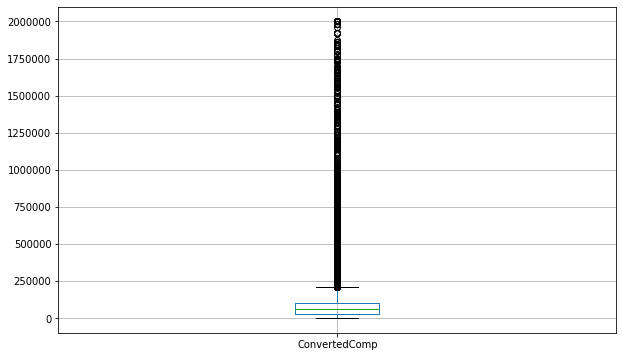

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
simple_data.boxplot("ConvertedComp")
fig.savefig("boxplot.png", bbox_inches='tight')

# Let's determine the outliers in Compensation

After determining the outliers we will exclude them from dataset

In [12]:
q1 = np.percentile(simple_data.ConvertedComp.values, 25)
q2 = np.percentile(simple_data.ConvertedComp.values, 50)
q3 = np.percentile(simple_data.ConvertedComp.values, 75)
iqr = q3 - q1

upper_boundary = q3 + 1.5*iqr
lower_boundary = q1 - 1.5*iqr
    
    # Determine if there are outliers
outlier1 = (simple_data.ConvertedComp > upper_boundary)
outlier2 = (simple_data.ConvertedComp < lower_boundary)

## Let's look at outliers

In [13]:
print("Number of Outliers: ", len(simple_data[outlier1]))
simple_data[outlier1].head()

Number of Outliers:  4476


,MainBranch,Hobbyist,Employment,DevType,Country,EdLevel,YearsCode,ConvertedComp,JobSat,JobSeek,LanguageWorkedWith,DatabaseWorkedWith,WebFrameWorkedWith,SOVisitFreq,Age,Gender
5,"I am not primarily a developer, but I write co...",Yes,Employed full-time,Data or business analyst;Data scientist or mac...,Canada,"Bachelor’s degree (BA, BS, B.Eng., etc.)",13,366420.0,Slightly satisfied,I am not interested in new job opportunities,Java;R;SQL,MongoDB;PostgreSQL,NaN,A few times per month or weekly,28.0,Man
15,I am a developer by profession,Yes,Employed full-time,"Developer, full-stack",United Kingdom,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",10,455352.0,Slightly satisfied,"I’m not actively looking, but I am open to new...",Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;T...,MongoDB;Microsoft SQL Server;MySQL,Angular/Angular.js;ASP.NET;jQuery,Multiple times per day,26.0,Man
31,I am a developer by profession,No,Employed full-time,"Developer, full-stack",United States,Associate degree,3,1100000.0,Slightly satisfied,I am actively looking for a job,Bash/Shell/PowerShell;HTML/CSS;JavaScript;PHP;...,MongoDB;PostgreSQL;Redis,Express;Flask,Multiple times per day,21.0,Man
57,I am a developer by profession,Yes,Employed full-time,"Developer, back-end;Developer, desktop or ente...",United States,"Bachelor’s degree (BA, BS, B.Eng., etc.)",28,2000000.0,Very satisfied,I am not interested in new job opportunities,C#;Java;SQL,Microsoft SQL Server;Oracle;SQLite,ASP.NET;jQuery,Multiple times per day,47.0,Man
99,I am a developer by profession,Yes,Employed full-time,"Developer, back-end;Developer, front-end;Devel...",Canada,Some college/university study without earning ...,33,229016.0,Very satisfied,I am not interested in new job opportunities,HTML/CSS;JavaScript;Ruby;SQL;TypeScript,PostgreSQL;Redis,Express;jQuery;React.js;Ruby on Rails,Daily or almost daily,39.0,Woman


In [14]:
simple_data[outlier2].any()

MainBranch            False
Hobbyist              False
Employment            False
DevType               False
Country               False
EdLevel               False
YearsCode             False
ConvertedComp         False
JobSat                False
JobSeek               False
LanguageWorkedWith    False
DatabaseWorkedWith    False
WebFrameWorkedWith    False
SOVisitFreq           False
Age                   False
Gender                False
dtype: bool

As we can observe from above outlier1 has 4476 outliers. but outlier2 has no outliers in it. It is what exactly we expected to have when we visualized the Compensation in boxplot.

# Let's remove outliers from our dataset

In [15]:
final_dataset = simple_data[~outlier1]
final_dataset

,MainBranch,Hobbyist,Employment,DevType,Country,EdLevel,YearsCode,ConvertedComp,JobSat,JobSeek,LanguageWorkedWith,DatabaseWorkedWith,WebFrameWorkedWith,SOVisitFreq,Age,Gender
2,"I am not primarily a developer, but I write co...",Yes,Employed full-time,"Designer;Developer, back-end;Developer, front-...",Thailand,"Bachelor’s degree (BA, BS, B.Eng., etc.)",3,8820.0,Slightly satisfied,"I’m not actively looking, but I am open to new...",HTML/CSS,PostgreSQL,NaN,A few times per week,28.0,Man
3,I am a developer by profession,No,Employed full-time,"Developer, full-stack",United States,"Bachelor’s degree (BA, BS, B.Eng., etc.)",3,61000.0,Slightly satisfied,I am not interested in new job opportunities,C;C++;C#;Python;SQL,MySQL;SQLite,NaN,Daily or almost daily,22.0,Man
8,I am a developer by profession,Yes,Employed full-time,"Database administrator;Developer, back-end;Dev...",New Zealand,Some college/university study without earning ...,12,95179.0,Slightly satisfied,"I’m not actively looking, but I am open to new...",Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;P...,DynamoDB;PostgreSQL;SQLite,Express;Ruby on Rails;Other(s):,Daily or almost daily,23.0,Man
9,I am a developer by profession,Yes,Employed full-time,Data or business analyst;Data scientist or mac...,India,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",12,13293.0,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",C#;Go;JavaScript;Python;R;SQL,Elasticsearch;MongoDB;Microsoft SQL Server;MyS...,Angular/Angular.js;ASP.NET;Django;Express;Flas...,Multiple times per day,NaN,NaN
12,I am a developer by profession,Yes,Employed full-time,Data or business analyst;Database administrato...,United States,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",17,90000.0,Very satisfied,I am not interested in new job opportunities,Bash/Shell/PowerShell;HTML/CSS;JavaScript;PHP;...,Couchbase;DynamoDB;Firebase;MySQL,Angular/Angular.js;ASP.NET;Express;jQuery;Vue.js,Multiple times per day,28.0,Man
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88323,I am a developer by profession,Yes,Employed full-time,"Developer, back-end;Developer, game or graphics",United States,"Bachelor’s degree (BA, BS, B.Eng., etc.)",8,180000.0,Slightly satisfied,"I’m not actively looking, but I am open to new...",Bash/Shell/PowerShell;C#;HTML/CSS;Java;Python;...,DynamoDB;MySQL,NaN,A few times per month or weekly,23.0,Man
88325,I am a developer by profession,Yes,Employed full-time,"Developer, back-end;Developer, front-end;Devel...",United States,"Bachelor’s degree (BA, BS, B.Eng., etc.)",12,130000.0,Very satisfied,I am not interested in new job opportunities,HTML/CSS;JavaScript;Scala;TypeScript,PostgreSQL,React.js;Other(s):,Multiple times per day,26.0,Man
88326,I am a developer by profession,Yes,Employed full-time,"Developer, desktop or enterprise applications;...",Finland,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",17,82488.0,Neither satisfied nor dissatisfied,"I’m not actively looking, but I am open to new...",Bash/Shell/PowerShell;C++;Python,NaN,NaN,A few times per month or weekly,34.0,Man
88328,I am a developer by profession,Yes,Employed full-time,"Developer, full-stack;Engineer, site reliability",Austria,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",18,68745.0,Neither satisfied nor dissatisfied,I am not interested in new job opportunities,Bash/Shell/PowerShell;Go;HTML/CSS;Java;JavaScr...,PostgreSQL;Redis,Django;React.js,A few times per month or weekly,37.0,Man


### Finally fill Nan values with "Others"
This is needed for proper functioning of our crossfilter function in JS. Of course it is not ideal solution since we have numerical columns as well. Filling it with "Others" may create problem in the future and ideal solution would be fill numerical columns based on interpolation. But for this effor "Others" is acceptable workaround.

In [16]:
final_dataset = final_dataset.fillna("Others")

# Database Creation and Data Ingestion

We will be using MongoDB for our database.

In [23]:
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

## Create StackOverFlow database and ingest developers collection into the databse in the form of python dictionary

In [24]:
db = client.stack_overflow
developers = db.developers_cleaned.find()

Iterate over simple_data DataFrame and add each row into stack_overflow database as a developer collection. Check for Nan values in "DatabaseWorkedWith" and "WebFrameWorkedWith" columns

In [25]:
for row in final_dataset.itertuples():
    developer_dict = {}
    developer_dict["MainBranch"] = getattr(row, "MainBranch")
    developer_dict["Hobbyist"] = getattr(row, "Hobbyist")
    developer_dict["Employment"] = getattr(row, "Employment")
    developer_dict["DevType"] = getattr(row, "DevType").split(";")
    developer_dict["Country"] = getattr(row, "Country")
    developer_dict["EdLevel"] = getattr(row, "EdLevel")
    developer_dict["YearsCode"] = getattr(row, "YearsCode")
    developer_dict["ConvertedComp"] = getattr(row, "ConvertedComp")
    developer_dict["JobSat"] = getattr(row, "JobSat")
    developer_dict["JobSeek"] = getattr(row, "JobSeek")
    developer_dict["LanguageWorkedWith"] = getattr(row, "LanguageWorkedWith").split(";")
    if pd.isna(getattr(row, "DatabaseWorkedWith")):
        developer_dict["DatabaseWorkedWith"] = None
    else:
        developer_dict["DatabaseWorkedWith"] = getattr(row, "DatabaseWorkedWith").split(";")
    if pd.isna(getattr(row, "WebFrameWorkedWith")):
        developer_dict["WebFrameWorkedWith"] = None
    else:
        developer_dict["WebFrameWorkedWith"] = getattr(row, "WebFrameWorkedWith").split(";")
    developer_dict["SOVisitFreq"] = getattr(row, "SOVisitFreq")
    developer_dict["Age"] = getattr(row, "Age")
    developer_dict["Gender"] = getattr(row, "Gender")
    db.developers_cleaned.insert_one(developer_dict)

In [26]:
test_data = final_dataset.iloc[0:2000]

In [27]:
test_data

,MainBranch,Hobbyist,Employment,DevType,Country,EdLevel,YearsCode,ConvertedComp,JobSat,JobSeek,LanguageWorkedWith,DatabaseWorkedWith,WebFrameWorkedWith,SOVisitFreq,Age,Gender
2,"I am not primarily a developer, but I write co...",Yes,Employed full-time,"Designer;Developer, back-end;Developer, front-...",Thailand,"Bachelor’s degree (BA, BS, B.Eng., etc.)",3,8820.0,Slightly satisfied,"I’m not actively looking, but I am open to new...",HTML/CSS,PostgreSQL,Others,A few times per week,28,Man
3,I am a developer by profession,No,Employed full-time,"Developer, full-stack",United States,"Bachelor’s degree (BA, BS, B.Eng., etc.)",3,61000.0,Slightly satisfied,I am not interested in new job opportunities,C;C++;C#;Python;SQL,MySQL;SQLite,Others,Daily or almost daily,22,Man
8,I am a developer by profession,Yes,Employed full-time,"Database administrator;Developer, back-end;Dev...",New Zealand,Some college/university study without earning ...,12,95179.0,Slightly satisfied,"I’m not actively looking, but I am open to new...",Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;P...,DynamoDB;PostgreSQL;SQLite,Express;Ruby on Rails;Other(s):,Daily or almost daily,23,Man
9,I am a developer by profession,Yes,Employed full-time,Data or business analyst;Data scientist or mac...,India,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",12,13293.0,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",C#;Go;JavaScript;Python;R;SQL,Elasticsearch;MongoDB;Microsoft SQL Server;MyS...,Angular/Angular.js;ASP.NET;Django;Express;Flas...,Multiple times per day,Others,Others
12,I am a developer by profession,Yes,Employed full-time,Data or business analyst;Database administrato...,United States,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",17,90000.0,Very satisfied,I am not interested in new job opportunities,Bash/Shell/PowerShell;HTML/CSS;JavaScript;PHP;...,Couchbase;DynamoDB;Firebase;MySQL,Angular/Angular.js;ASP.NET;Express;jQuery;Vue.js,Multiple times per day,28,Man
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,I am a developer by profession,No,Employed full-time,"Developer, full-stack",Canada,"Bachelor’s degree (BA, BS, B.Eng., etc.)",18,133592.0,Very satisfied,"I’m not actively looking, but I am open to new...",Java;JavaScript;SQL,Oracle;SQLite,Others,A few times per week,36,Man
3498,I am a developer by profession,Yes,Employed full-time,"Designer;Developer, back-end;Developer, front-end",United States,"Bachelor’s degree (BA, BS, B.Eng., etc.)",13,70000.0,Slightly satisfied,"I’m not actively looking, but I am open to new...",HTML/CSS;JavaScript;PHP,MySQL,jQuery,A few times per month or weekly,33,Man
3504,I am a developer by profession,Yes,Employed full-time,"Developer, full-stack",India,"Bachelor’s degree (BA, BS, B.Eng., etc.)",6,19590.0,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",Elixir;HTML/CSS;JavaScript;SQL;TypeScript,MongoDB;MySQL,Angular/Angular.js;Express,A few times per week,24,Man
3506,I am a developer by profession,Yes,Employed full-time,"Developer, front-end",United Kingdom,"Bachelor’s degree (BA, BS, B.Eng., etc.)",7,30095.0,Very satisfied,I am not interested in new job opportunities,HTML/CSS;JavaScript;PHP,MySQL,jQuery,Daily or almost daily,23,Man


In [28]:
json_list = []
for row in test_data.itertuples():
    developer_dict = {}
    developer_dict["MainBranch"] = getattr(row, "MainBranch")
    developer_dict["Hobbyist"] = getattr(row, "Hobbyist")
    developer_dict["Employment"] = getattr(row, "Employment")
    developer_dict["DevType"] = getattr(row, "DevType")
    developer_dict["Country"] = getattr(row, "Country")
    developer_dict["EdLevel"] = getattr(row, "EdLevel")
    developer_dict["YearsCode"] = getattr(row, "YearsCode")
    developer_dict["ConvertedComp"] = getattr(row, "ConvertedComp")
    developer_dict["JobSat"] = getattr(row, "JobSat")
    developer_dict["JobSeek"] = getattr(row, "JobSeek")
    developer_dict["LanguageWorkedWith"] = getattr(row, "LanguageWorkedWith")
    if pd.isna(getattr(row, "DatabaseWorkedWith")):
        developer_dict["DatabaseWorkedWith"] = None
    else:
        developer_dict["DatabaseWorkedWith"] = getattr(row, "DatabaseWorkedWith")
    if pd.isna(getattr(row, "WebFrameWorkedWith")):
        developer_dict["WebFrameWorkedWith"] = None
    else:
        developer_dict["WebFrameWorkedWith"] = getattr(row, "WebFrameWorkedWith")
    developer_dict["SOVisitFreq"] = getattr(row, "SOVisitFreq")
    developer_dict["Age"] = getattr(row, "Age")
    developer_dict["Gender"] = getattr(row, "Gender")
    json_list.append(developer_dict)

In [29]:
len(json_list)

2000

In [30]:
with open('data.json', 'w') as json_file:
    json.dump(json_list, json_file)

In [31]:
test_data = pd.read_json("data.json")

In [32]:
with open('data.json', 'r') as json_file:
    data = json.load(json_file)
    pprint(data)

[{'Age': 28.0,
  'ConvertedComp': 8820.0,
  'Country': 'Thailand',
  'DatabaseWorkedWith': 'PostgreSQL',
  'DevType': 'Designer;Developer, back-end;Developer, front-end;Developer, '
             'full-stack',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'HTML/CSS',
  'MainBranch': 'I am not primarily a developer, but I write code sometimes as '
                'part of my work',
  'SOVisitFreq': 'A few times per week',
  'WebFrameWorkedWith': 'Others',
  'YearsCode': '3'},
 {'Age': 22.0,
  'ConvertedComp': 61000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'MySQL;SQLite',
  'DevType': 'Developer, full-stack',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'No',
  'JobSat': 

  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'ASP.NET;jQuery',
  'YearsCode': '7'},
 {'Age': 30.0,
  'ConvertedComp': 110000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'Microsoft SQL Server;PostgreSQL',
  'DevType': 'Developer, full-stack;DevOps specialist;Engineer, data',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'No',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'C#;HTML/CSS;JavaScript;Python;R;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'Angular/Angular.js',
  'YearsCode': '11'},
 {'Age': 25.0,
  'ConvertedComp': 66750.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'Other(s):',
  'DevType': 'Data or business analyst;Data scientist or machine learning '
             'specialist;Developer, back-end;Educator;En

  'ConvertedComp': 36265.0,
  'Country': 'Australia',
  'DatabaseWorkedWith': 'Microsoft SQL Server;MySQL;SQLite',
  'DevType': 'Database administrator;Developer, back-end;Developer, desktop or '
             'enterprise applications;Developer, embedded applications or '
             'devices;Developer, full-stack;Developer, mobile;Student',
  'EdLevel': 'Some college/university study without earning a degree',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'C#;Python;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'ASP.NET',
  'YearsCode': '5'},
 {'Age': 28.0,
  'ConvertedComp': 2500.0,
  'Country': 'India',
  'DatabaseWorkedWith': 'Firebase;MongoDB;MySQL;PostgreSQL',
  'DevType': 'Developer, full-stack',
  'EdLevel': 'Others',
  'Employment': 'Ind

  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'jQuery',
  'YearsCode': '13'},
 {'Age': 44.0,
  'ConvertedComp': 90000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'Others',
  'DevType': 'Designer;Developer, embedded applications or devices',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Assembly;Bash/Shell/PowerShell;C;Python;VBA',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'A few times per week',
  'WebFrameWorkedWith': 'Others',
  'YearsCode': '20'},
 {'Age': 33.0,
  'Conver

  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'Django;Express;Flask;jQuery;React.js',
  'YearsCode': '7'},
 {'Age': 35.0,
  'ConvertedComp': 38952.0,
  'Country': 'Mexico',
  'DatabaseWorkedWith': 'Microsoft SQL Server',
  'DevType': 'Developer, back-end;Developer, desktop or enterprise '
             'applications',
  'EdLevel': 'Some college/university study without earning a degree',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'C#;HTML/CSS;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'A few times per week',
  'WebFrameWorkedWith': 'ASP.NET;jQuery',
  'YearsCode': '20'},
 {'Age': 23.0,
  'ConvertedComp': 46992.0,
  'Country': 'France',
  'DatabaseWorkedWith': 'Microsoft SQL Server;MySQL',
  'DevType': 'Developer, back-en

  'Hobbyist': 'Yes',
  'JobSat': 'Slightly dissatisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;JavaScript;Python;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'Django;Flask;React.js',
  'YearsCode': '34'},
 {'Age': 50.0,
  'ConvertedComp': 130000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'Elasticsearch;PostgreSQL;Redis',
  'DevType': 'Developer, full-stack',
  'EdLevel': 'Some college/university study without earning a degree',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very dissatisfied',
  'JobSeek': 'I am actively looking for a job',
  'LanguageWorkedWith': 'HTML/CSS;JavaScript;Ruby',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'A few times per month or weekly',
  'WebFrameWorkedWith': 'Ruby on Rails;Vue.js',
  'YearsCode': '39'},
 {'Age': 21.0,
  'Conv

 {'Age': 41.0,
  'ConvertedComp': 68745.0,
  'Country': 'France',
  'DatabaseWorkedWith': 'Firebase;MySQL',
  'DevType': 'Developer, desktop or enterprise applications;Developer, '
             'front-end;Developer, full-stack;Developer, '
             'mobile;Educator;Product manager',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Neither satisfied nor dissatisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Dart;JavaScript;Kotlin;PHP;SQL;Swift;TypeScript',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'A few times per week',
  'WebFrameWorkedWith': 'Angular/Angular.js;React.js;Other(s):',
  'YearsCode': '30'},
 {'Age': 25.0,
  'ConvertedComp': 97000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'PostgreSQL',
  'DevType': 'Developer, front-end',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng.,

  'EdLevel': 'Some college/university study without earning a degree',
  'Employment': 'Independent contractor, freelancer, or self-employed',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly dissatisfied',
  'JobSeek': 'I am actively looking for a job',
  'LanguageWorkedWith': 'C#;HTML/CSS;JavaScript;Ruby;SQL;TypeScript',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'Angular/Angular.js;Express;jQuery;Ruby on Rails',
  'YearsCode': '6'},
 {'Age': 28.0,
  'ConvertedComp': 100000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'MariaDB;Microsoft SQL Server;PostgreSQL',
  'DevType': 'Database administrator;Designer;Developer, back-end;Developer, '
             'front-end;Developer, full-stack;Developer, mobile;Developer, QA '
             'or test;System administrator',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 

  'DatabaseWorkedWith': 'MySQL',
  'DevType': 'Developer, front-end;Developer, full-stack;Developer, mobile',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'C++;HTML/CSS;Java;JavaScript;TypeScript',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'jQuery;React.js',
  'YearsCode': '12'},
 {'Age': 28.0,
  'ConvertedComp': 45830.0,
  'Country': 'France',
  'DatabaseWorkedWith': 'Cassandra;MongoDB;Redis',
  'DevType': 'Data scientist or machine learning specialist;Student',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Woman',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly dissatisfied',
  'JobSeek': 'I am actively looking for a job',
  'LanguageW

  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'No',
  'JobSat': 'Slightly dissatisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;Go;SQL;TypeScript',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'Express',
  'YearsCode': '18'},
 {'Age': 39.0,
  'ConvertedComp': 125000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'Others',
  'DevType': 'Developer, back-end;Developer, embedded applications or '
             'devices;Developer, full-stack',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;C;C++;C#;HTML/CSS;Java;JavaScript;Python',
  'MainBranch': 'I am a develo

  'Country': 'Germany',
  'DatabaseWorkedWith': 'Others',
  'DevType': 'Developer, back-end;Developer, front-end;Developer, full-stack',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;HTML/CSS;JavaScript;PHP',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'A few times per week',
  'WebFrameWorkedWith': 'Express;React.js',
  'YearsCode': '7'},
 {'Age': 24.0,
  'ConvertedComp': 82000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'Microsoft SQL Server;PostgreSQL',
  'DevType': 'Developer, full-stack',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I’m not actively looking, but I am o

  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;Go;JavaScript;Python;Rust;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'Others',
  'YearsCode': '9'},
 {'Age': 29.0,
  'ConvertedComp': 18336.0,
  'Country': 'Russian Federation',
  'DatabaseWorkedWith': 'Oracle;PostgreSQL',
  'DevType': 'Developer, back-end;Developer, desktop or enterprise '
             'applications',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Others',
  'Hobbyist': 'No',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Java;SQL;Other(s):',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'A few times per mo

  'DevType': 'Developer, back-end;Developer, full-stack',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;C++;HTML/CSS;Java;Ruby;SQL;TypeScript',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'A few times per month or weekly',
  'WebFrameWorkedWith': 'Angular/Angular.js;Spring',
  'YearsCode': '11'},
 {'Age': 35.0,
  'ConvertedComp': 85051.0,
  'Country': 'United Kingdom',
  'DatabaseWorkedWith': 'Others',
  'DevType': 'Developer, embedded applications or devices;Scientist',
  'EdLevel': 'Other doctoral degree (Ph.D, Ed.D., etc.)',
  'Employment': 'Independent contractor, freelancer, or self-employed',
  'Gender': 'Man',
  'Hobbyist': 'No',
  'JobSat': 'Neither satisfied nor dissatisfied',
  'JobSeek': 'I am not interested in new job opportunit

 {'Age': 27.0,
  'ConvertedComp': 37692.0,
  'Country': 'Mexico',
  'DatabaseWorkedWith': 'DynamoDB;Elasticsearch;MySQL;PostgreSQL;Redis',
  'DevType': 'Academic researcher;Developer, back-end;DevOps specialist;System '
             'administrator',
  'EdLevel': 'Some college/university study without earning a degree',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Clojure;Go;Python',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'Others',
  'YearsCode': '8'},
 {'Age': 38.0,
  'ConvertedComp': 89368.0,
  'Country': 'Finland',
  'DatabaseWorkedWith': 'MariaDB;MongoDB;PostgreSQL;Other(s):',
  'DevType': 'Senior executive/VP',
  'EdLevel': 'Some college/university study without earning a degree',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  

  'DatabaseWorkedWith': 'Microsoft SQL Server',
  'DevType': 'Developer, back-end;Developer, desktop or enterprise '
             'applications;Developer, full-stack',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'No',
  'JobSat': 'Very dissatisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'C#;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'ASP.NET',
  'YearsCode': '16'},
 {'Age': 37.0,
  'ConvertedComp': 118325.0,
  'Country': 'Canada',
  'DatabaseWorkedWith': 'MongoDB;Microsoft SQL Server',
  'DevType': 'Developer, full-stack;DevOps specialist;System administrator',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'No',
  'JobSat': 'Very dissatisfied',
  'JobSeek': 'I am not interested i

  'JobSat': 'Neither satisfied nor dissatisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Assembly;Bash/Shell/PowerShell;C;Objective-C;Python;Ruby;Swift',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'Others',
  'YearsCode': '4'},
 {'Age': 25.0,
  'ConvertedComp': 120000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'MySQL;PostgreSQL;Redis;SQLite',
  'DevType': 'Developer, full-stack',
  'EdLevel': 'Some college/university study without earning a degree',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;HTML/CSS;JavaScript;Ruby;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'jQuery;Ruby on 

  'LanguageWorkedWith': 'Bash/Shell/PowerShell;C;C++;C#;HTML/CSS;Java;JavaScript;Kotlin;Objective-C;Ruby;Swift',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'Angular/Angular.js;Express;jQuery;React.js;Ruby on '
                        'Rails',
  'YearsCode': '12'},
 {'Age': 28.0,
  'ConvertedComp': 100000.0,
  'Country': 'China',
  'DatabaseWorkedWith': 'DynamoDB;Elasticsearch;Firebase;MariaDB;MongoDB;Microsoft '
                        'SQL Server;MySQL;Redis;SQLite',
  'DevType': 'Database administrator;Designer;Developer, back-end;Developer, '
             'desktop or enterprise applications;Developer, '
             'front-end;Developer, full-stack;Developer, mobile',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Independent contractor, freelancer, or self-employed',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I am actively looking for a jo

  'ConvertedComp': 76994.0,
  'Country': 'Spain',
  'DatabaseWorkedWith': 'MySQL;SQLite',
  'DevType': 'Academic researcher',
  'EdLevel': 'Other doctoral degree (Ph.D, Ed.D., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;PHP;Python;R;SQL',
  'MainBranch': 'I am not primarily a developer, but I write code sometimes as '
                'part of my work',
  'SOVisitFreq': 'A few times per week',
  'WebFrameWorkedWith': 'ASP.NET;jQuery',
  'YearsCode': '9'},
 {'Age': 33.0,
  'ConvertedComp': 52339.0,
  'Country': 'United Kingdom',
  'DatabaseWorkedWith': 'MariaDB;Redis',
  'DevType': 'Database administrator;Developer, back-end;Developer, '
             'full-stack;System administrator',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed fu

  'WebFrameWorkedWith': 'Django;Flask',
  'YearsCode': '2'},
 {'Age': 34.0,
  'ConvertedComp': 100000.0,
  'Country': 'Russian Federation',
  'DatabaseWorkedWith': 'Firebase',
  'DevType': 'Developer, mobile',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'C++;Java;Kotlin;Objective-C;Swift',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'Others',
  'YearsCode': '10'},
 {'Age': 35.0,
  'ConvertedComp': 83640.0,
  'Country': 'Netherlands',
  'DatabaseWorkedWith': 'Cassandra;Elasticsearch;MySQL;Oracle',
  'DevType': 'Developer, back-end;Developer, full-stack',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat'

  'WebFrameWorkedWith': 'Flask',
  'YearsCode': '2'},
 {'Age': 22.0,
  'ConvertedComp': 41871.0,
  'Country': 'United Kingdom',
  'DatabaseWorkedWith': 'DynamoDB;Oracle',
  'DevType': 'Developer, back-end;Developer, desktop or enterprise '
             'applications;Developer, front-end;Developer, '
             'full-stack;Developer, mobile;Engineer, data',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'No',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;HTML/CSS;Java;JavaScript;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'React.js;Spring',
  'YearsCode': '6'},
 {'Age': 23.0,
  'ConvertedComp': 52339.0,
  'Country': 'United Kingdom',
  'DatabaseWorkedWith': 'Microsoft SQL Server',
  'DevType': 'Data or business analys

  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;Go;Java;Kotlin;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'A few times per week',
  'WebFrameWorkedWith': 'Angular/Angular.js;Spring',
  'YearsCode': '18'},
 {'Age': 34.0,
  'ConvertedComp': 34982.0,
  'Country': 'India',
  'DatabaseWorkedWith': 'Others',
  'DevType': 'Developer, desktop or enterprise applications;Product manager',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'No',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'C#;Java',
  'MainBranch': 'I am a developer by profession',
  'SOVisit

  'Country': 'Brazil',
  'DatabaseWorkedWith': 'Cassandra;MariaDB;MongoDB;PostgreSQL',
  'DevType': 'Designer;Developer, full-stack;Developer, game or '
             'graphics;Developer, mobile',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Independent contractor, freelancer, or self-employed',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Neither satisfied nor dissatisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Elixir;HTML/CSS;JavaScript;PHP;Python',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'A few times per week',
  'WebFrameWorkedWith': 'Laravel',
  'YearsCode': '8'},
 {'Age': 42.0,
  'ConvertedComp': 66276.0,
  'Country': 'Sweden',
  'DatabaseWorkedWith': 'MongoDB;Microsoft SQL Server;Oracle',
  'DevType': 'Developer, full-stack',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist'

 {'Age': 30.0,
  'ConvertedComp': 61650.0,
  'Country': 'Australia',
  'DatabaseWorkedWith': 'Microsoft SQL Server;MySQL',
  'DevType': 'Developer, back-end;Developer, desktop or enterprise '
             'applications;Developer, front-end;Developer, full-stack;DevOps '
             'specialist',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;HTML/CSS;JavaScript;PHP;Python;SQL;TypeScript',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Less than once per month or monthly',
  'WebFrameWorkedWith': 'Express;jQuery;Laravel;React.js;Ruby on Rails',
  'YearsCode': '15'},
 {'Age': 34.0,
  'ConvertedComp': 68745.0,
  'Country': 'France',
  'DatabaseWorkedWith': 'Redis',
  'DevType': 'Developer, full-stack',
  'EdLevel': 'Master’s 

  'DevType': 'Data or business analyst;Database '
             'administrator;Designer;Developer, back-end;Developer, desktop or '
             'enterprise applications;Developer, front-end;Developer, '
             'full-stack;Developer, QA or test;Product manager',
  'EdLevel': 'Associate degree',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'No',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'C#;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'ASP.NET',
  'YearsCode': '30'},
 {'Age': 25.0,
  'ConvertedComp': 63240.0,
  'Country': 'Finland',
  'DatabaseWorkedWith': 'Firebase;MongoDB;PostgreSQL;Other(s):',
  'DevType': 'Data scientist or machine learning specialist;Developer, '
             'back-end;Developer, desktop or enterprise '
             'applications;Developer, front-end;Developer, '
        

  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly dissatisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'C#;HTML/CSS;JavaScript;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'A few times per week',
  'WebFrameWorkedWith': 'ASP.NET;jQuery',
  'YearsCode': '22'},
 {'Age': 30.0,
  'ConvertedComp': 3823.0,
  'Country': 'Philippines',
  'DatabaseWorkedWith': 'DynamoDB;Microsoft SQL Server;PostgreSQL;Redis',
  'DevType': 'Developer, full-stack',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;C#;HTML/CSS;Java;JavaScript;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'A few times per week',
  'WebFrameWorkedWith': 'ASP.NET;React.js;Spring',
  'Yea

  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'ASP.NET',
  'YearsCode': '35'},
 {'Age': 45.0,
  'ConvertedComp': 79536.0,
  'Country': 'Sweden',
  'DatabaseWorkedWith': 'Redis;Other(s):',
  'DevType': 'Developer, back-end;Developer, desktop or enterprise '
             'applications',
  'EdLevel': 'Some college/university study without earning a degree',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'C++;C#',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'ASP.NET;Vue.js',
  'YearsCode': '33'},
 {'Age': 23.0,
  'ConvertedComp': 5196.0,
  'Country': 'Pakistan',
  'DatabaseWorkedWith': 'MySQL;PostgreSQL;Redis;SQLite',
  'DevType': 'Developer, back-end',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gende

  'DevType': 'Developer, game or graphics;Engineer, data;Student',
  'EdLevel': 'Some college/university study without earning a degree',
  'Employment': 'Independent contractor, freelancer, or self-employed',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Neither satisfied nor dissatisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'C#;JavaScript;Python',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'Angular/Angular.js;Django',
  'YearsCode': '6'},
 {'Age': 26.0,
  'ConvertedComp': 15708.0,
  'Country': 'Poland',
  'DatabaseWorkedWith': 'Microsoft SQL Server',
  'DevType': 'Developer, desktop or enterprise applications',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Neither satisfied nor dissatisfied',
  'JobSeek': 'I’m not actively looking, but I

  'YearsCode': '11'},
 {'Age': 26.0,
  'ConvertedComp': 35116.0,
  'Country': 'Canada',
  'DatabaseWorkedWith': 'Oracle',
  'DevType': 'Developer, full-stack',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'C#;HTML/CSS;JavaScript',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'Angular/Angular.js;ASP.NET',
  'YearsCode': '11'},
 {'Age': 32.0,
  'ConvertedComp': 30528.0,
  'Country': 'Portugal',
  'DatabaseWorkedWith': 'Elasticsearch',
  'DevType': 'Developer, back-end;Developer, desktop or enterprise '
             'applications;Developer, front-end;Developer, '
             'full-stack;Developer, game or graphics;Developer, mobile',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'E

  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;C#;Elixir;Go;HTML/CSS;JavaScript;Ruby;Scala;Swift',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'A few times per month or weekly',
  'WebFrameWorkedWith': 'Ruby on Rails',
  'YearsCode': '39'},
 {'Age': 27.0,
  'ConvertedComp': 70000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'Others',
  'DevType': 'Developer, front-end;Developer, mobile;Educator',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'No',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;Java;Swift',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'A few times per month or weekly',
  'WebFrameWorkedWith': 'Others',
  'YearsCode': '12'},
 {'Age': 36.0,
  'ConvertedComp': 87789.0,
  'Country': 'Cana

  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'Others',
  'YearsCode': '15'},
 {'Age': 24.0,
  'ConvertedComp': 11520.0,
  'Country': 'Turkey',
  'DatabaseWorkedWith': 'Cassandra;DynamoDB;Elasticsearch;MongoDB;MySQL;PostgreSQL;Redis',
  'DevType': 'Developer, back-end;Developer, front-end;Developer, '
             'full-stack;DevOps specialist;Engineer, data;Senior executive/VP',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;C++;Elixir;HTML/CSS;Java;JavaScript;Python;Scala;SQL;TypeScript',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'Flask;jQuery;React.js;Vue.js',
  'YearsCode': '4'},
 {'Age': 26.0,
  'ConvertedComp': 47100.0,
  'Country': 'United Kingdom',
  'Databas

             'full-stack',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;HTML/CSS;JavaScript;Objective-C;PHP;Python;Ruby;SQL;Swift',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'Laravel',
  'YearsCode': '15'},
 {'Age': 31.0,
  'ConvertedComp': 81000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'MySQL',
  'DevType': 'Database administrator;Developer, back-end;Developer, '
             'full-stack;Developer, QA or test',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Woman',
  'Hobbyist': 'Yes',
  'JobSat': 'Very dissatisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedW

  'Country': 'United States',
  'DatabaseWorkedWith': 'MongoDB',
  'DevType': 'Developer, back-end;Developer, full-stack',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly dissatisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Java;JavaScript',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Less than once per month or monthly',
  'WebFrameWorkedWith': 'Spring',
  'YearsCode': '3'},
 {'Age': 28.0,
  'ConvertedComp': 15816.0,
  'Country': 'Greece',
  'DatabaseWorkedWith': 'Firebase;MariaDB;MySQL;Oracle;SQLite',
  'DevType': 'Academic researcher;Database administrator;Developer, '
             'front-end;Developer, full-stack;Engineer, data;Student',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 

  'Hobbyist': 'No',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;HTML/CSS;JavaScript;PHP;SQL;TypeScript',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'Angular/Angular.js;jQuery;Laravel;Vue.js;Other(s):',
  'YearsCode': '10'},
 {'Age': 29.0,
  'ConvertedComp': 6720.0,
  'Country': 'India',
  'DatabaseWorkedWith': 'SQLite',
  'DevType': 'Developer, mobile',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'HTML/CSS;Java;Kotlin;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'Others',
  'YearsCode': '9'},
 {'Age': 27.0,
  'ConvertedComp

  'YearsCode': '9'},
 {'Age': 28.0,
  'ConvertedComp': 39166.0,
  'Country': 'Australia',
  'DatabaseWorkedWith': 'MariaDB',
  'DevType': 'Developer, full-stack',
  'EdLevel': 'Some college/university study without earning a degree',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'HTML/CSS;JavaScript;PHP;SQL;TypeScript',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'Angular/Angular.js;jQuery;Laravel;Vue.js',
  'YearsCode': '13'},
 {'Age': 23.0,
  'ConvertedComp': 80000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'DynamoDB;MySQL',
  'DevType': 'DevOps specialist',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': '

  'WebFrameWorkedWith': 'Django',
  'YearsCode': '8'},
 {'Age': 32.0,
  'ConvertedComp': 54996.0,
  'Country': 'Netherlands',
  'DatabaseWorkedWith': 'Microsoft SQL Server;MySQL',
  'DevType': 'Developer, desktop or enterprise applications;Developer, '
             'full-stack;DevOps specialist',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;C#;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'ASP.NET;Vue.js',
  'YearsCode': '15'},
 {'Age': 38.0,
  'ConvertedComp': 105000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'Elasticsearch;MongoDB;PostgreSQL',
  'DevType': 'Developer, front-end;Developer, full-stack',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment'

  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very dissatisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'C#;SQL',
  'MainBranch': 'I am not primarily a developer, but I write code sometimes as '
                'part of my work',
  'SOVisitFreq': 'A few times per week',
  'WebFrameWorkedWith': 'Others',
  'YearsCode': '20'},
 {'Age': 38.0,
  'ConvertedComp': 68745.0,
  'Country': 'Netherlands',
  'DatabaseWorkedWith': 'Cassandra;PostgreSQL;Redis',
  'DevType': 'Data scientist or machine learning specialist;Developer, '
             'back-end;Engineer, data;Scientist',
  'EdLevel': 'Other doctoral degree (Ph.D, Ed.D., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Bash/

  'YearsCode': '9'},
 {'Age': 30.0,
  'ConvertedComp': 36060.0,
  'Country': 'Brazil',
  'DatabaseWorkedWith': 'DynamoDB;Elasticsearch;MongoDB;Oracle;PostgreSQL;Redis;SQLite',
  'DevType': 'Developer, back-end;Developer, full-stack;Scientist',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'No',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;HTML/CSS;JavaScript;Python;R;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'Express;Flask;React.js',
  'YearsCode': '13'},
 {'Age': 36.0,
  'ConvertedComp': 68748.0,
  'Country': 'Slovakia',
  'DatabaseWorkedWith': 'Others',
  'DevType': 'Developer, back-end;Developer, front-end;Developer, full-stack',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 'Independent contract

             'administrator',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Others',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly dissatisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;JavaScript;PHP;TypeScript',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'Angular/Angular.js;jQuery;Vue.js',
  'YearsCode': '8'},
 {'Age': 35.0,
  'ConvertedComp': 27478.0,
  'Country': 'United Kingdom',
  'DatabaseWorkedWith': 'MariaDB;SQLite',
  'DevType': 'Data or business analyst;Data scientist or machine learning '
             'specialist;Database administrator;Developer, back-end;Developer, '
             'front-end;Developer, full-stack;Engineer, data',
  'EdLevel': 'Some college/university study without earning a degree',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hob

  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'jQuery',
  'YearsCode': '10'},
 {'Age': 29.0,
  'ConvertedComp': 125000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'DynamoDB;MySQL;PostgreSQL;Redis',
  'DevType': 'Developer, back-end',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'No',
  'JobSat': 'Slightly dissatisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;HTML/CSS;JavaScript;Ruby',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'A few times per week',
  'WebFrameWorkedWith': 'Angular/Angular.js;jQuery;Ruby on Rails;Vue.js',
  'YearsCode': '12'},
 {'Age': 32.0,
  'ConvertedComp': 0.0,
  'Country': 'Russian Federation',
  'DatabaseWorkedWith': 'Others',
  'DevType': 'Developer, back-end;Developer, desktop or enterprise '
             'applications;Developer, front-en

  'Country': 'United States',
  'DatabaseWorkedWith': 'Firebase;Microsoft SQL Server;MySQL',
  'DevType': 'Developer, full-stack',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Woman',
  'Hobbyist': 'No',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;C#;HTML/CSS;Java;JavaScript;Ruby',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'React.js;Ruby on Rails',
  'YearsCode': '3'},
 {'Age': 23.0,
  'ConvertedComp': 28860.0,
  'Country': 'Poland',
  'DatabaseWorkedWith': 'Microsoft SQL Server',
  'DevType': 'Developer, back-end;Developer, desktop or enterprise '
             'applications;Developer, full-stack',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied'

  'YearsCode': 'Less than 1 year'},
 {'Age': 33.0,
  'ConvertedComp': 27498.0,
  'Country': 'Spain',
  'DatabaseWorkedWith': 'MariaDB;Microsoft SQL Server;SQLite',
  'DevType': 'Developer, back-end;Developer, desktop or enterprise '
             'applications;Developer, full-stack;Developer, mobile;Developer, '
             'QA or test',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'HTML/CSS;Java;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'Spring',
  'YearsCode': '7'},
 {'Age': 30.0,
  'ConvertedComp': 90000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'Microsoft SQL Server;MySQL;PostgreSQL;Redis',
  'DevType': 'Database administrator;Designer;Developer, back-end;Developer

  'DatabaseWorkedWith': 'Elasticsearch;Firebase;MongoDB;PostgreSQL;Redis',
  'DevType': 'Designer;Developer, back-end;Developer, front-end;Developer, '
             'full-stack;Developer, game or graphics;Student',
  'EdLevel': 'Some college/university study without earning a degree',
  'Employment': 'Employed full-time',
  'Gender': 'Non-binary, genderqueer, or gender non-conforming',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly dissatisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;C;C++;Go;HTML/CSS;Java;JavaScript;Kotlin;Python;SQL;Swift;TypeScript;WebAssembly;Other(s):',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'Angular/Angular.js;Django;Express;Flask;jQuery;React.js;Ruby '
                        'on Rails',
  'YearsCode': '10'},
 {'Age': 23.0,
  'ConvertedComp': 14436.0,
  'Country': 'Spain',
  'DatabaseWorkedWith': 'Microsof

  'ConvertedComp': 200000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'Cassandra;DynamoDB;Elasticsearch;MongoDB;MySQL;PostgreSQL;Redis;SQLite',
  'DevType': 'Developer, back-end;DevOps specialist;Engineer, site reliability',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'Bash/Shell/PowerShell;Go;JavaScript;Python;Ruby;Scala;SQL;TypeScript',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Multiple times per day',
  'WebFrameWorkedWith': 'Angular/Angular.js;Express;Ruby on Rails',
  'YearsCode': '6'},
 {'Age': 48.0,
  'ConvertedComp': 49176.0,
  'Country': 'Brazil',
  'DatabaseWorkedWith': 'Microsoft SQL Server',
  'DevType': 'Educator;Scientist',
  'EdLevel': 'Other doctoral degree (Ph.D, Ed.D., etc.)',
  'Employment': 'Employed full-time',
  'Gender': '

  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'Spring',
  'YearsCode': '38'},
 {'Age': 34.0,
  'ConvertedComp': 12000.0,
  'Country': 'Brazil',
  'DatabaseWorkedWith': 'Firebase;SQLite',
  'DevType': 'Developer, full-stack;Senior executive/VP;System administrator',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I am not interested in new job opportunities',
  'LanguageWorkedWith': 'C#;HTML/CSS;JavaScript;SQL',
  'MainBranch': 'I am a developer by profession',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'ASP.NET',
  'YearsCode': '2'},
 {'Age': 24.0,
  'ConvertedComp': 39768.0,
  'Country': 'Sweden',
  'DatabaseWorkedWith': 'SQLite',
  'DevType': 'Developer, embedded applications or devices',
  'EdLevel': 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
  'Employment': 

  'DatabaseWorkedWith': 'Others',
  'DevType': 'Academic researcher',
  'EdLevel': 'Other doctoral degree (Ph.D, Ed.D., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Slightly satisfied',
  'JobSeek': 'I am actively looking for a job',
  'LanguageWorkedWith': 'R',
  'MainBranch': 'I am not primarily a developer, but I write code sometimes as '
                'part of my work',
  'SOVisitFreq': 'Daily or almost daily',
  'WebFrameWorkedWith': 'Others',
  'YearsCode': '3'},
 {'Age': 26.0,
  'ConvertedComp': 35000.0,
  'Country': 'United States',
  'DatabaseWorkedWith': 'Firebase;MongoDB;MySQL',
  'DevType': 'Developer, front-end',
  'EdLevel': 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
  'Employment': 'Employed full-time',
  'Gender': 'Man',
  'Hobbyist': 'Yes',
  'JobSat': 'Very satisfied',
  'JobSeek': 'I’m not actively looking, but I am open to new opportunities',
  'LanguageWorkedWith': 'HTML/CSS;JavaScript;PHP',
  'MainBranch': '